In [1]:
# Libraries
import pandas as pd
import numpy  as np
import re
import warnings
import matplotlib.pyplot  as plt
import matplotlib.patches as mpatches

from sklearn.preprocessing import StandardScaler
from sklearn.cluster       import KMeans
from sklearn.cluster       import AgglomerativeClustering
from sklearn.cluster       import DBSCAN
from sklearn.metrics       import accuracy_score
from sklearn.metrics       import confusion_matrix
from sklearn.metrics       import plot_confusion_matrix
from sklearn.decomposition import PCA
from sklearn.ensemble      import RandomForestClassifier
from sklearn.utils         import resample

warnings.filterwarnings('ignore')

In [2]:
# local file paths
dir_name = 'preparazione'

fp_xtrain = dir_name + "/X_train.csv"
fp_ytrain = dir_name + "/y_train.csv"
fp_xval   = dir_name + "/X_val.csv"
fp_yval   = dir_name + "/y_val.csv"
fp_xtest  = dir_name + "/X_test.csv"
fp_ytest  = dir_name + "/y_test.csv"

In [3]:
# Reading dataframes
X_train = pd.read_csv(fp_xtrain, low_memory=False)
y_train = pd.read_csv(fp_ytrain, low_memory=False)
X_val   = pd.read_csv(fp_xval,   low_memory=False)
y_val   = pd.read_csv(fp_yval,   low_memory=False)
X_test  = pd.read_csv(fp_xtest,  low_memory=False)
y_test  = pd.read_csv(fp_ytest,  low_memory=False)

In [4]:
# Removes from the given dataframe the column with the given name
def remove_column(df, col_names):
    df.drop(col_names, axis=1, inplace=True)
    return df

In [5]:
for X in [X_train, X_val, X_test]:
    X = remove_column(X, ['parcelid'])

In [6]:
# Prints all dataframes shape
def dimensionality(y=False):
    print(f'X_train {  X_train.shape}')
    print(f'X_val   {    X_val.shape}')
    print(f'X_test  {   X_test.shape}')
    if y:
        print(f'y_train { y_train.shape}')
        print(f'y_val   {   y_val.shape}')
        print(f'y_test  {  y_test.shape}')

In [7]:
dimensionality(y=True)

X_train (99709, 72)
X_val   (33572, 72)
X_test  (33567, 72)
y_train (99709, 1)
y_val   (33572, 1)
y_test  (33567, 1)


In [8]:
print(*X_train.columns, sep='\n')

bathroomcnt
bedroomcnt
buildingqualitytypeid
calculatedbathnbr
calculatedfinishedsquarefeet
finishedsquarefeet12
fireplacecnt
latitude
longitude
lotsizesquarefeet
rawcensustractandblock
regionidcity
regionidzip
roomcnt
unitcnt
yearbuilt
structuretaxvaluedollarcnt
taxvaluedollarcnt
assessmentyear
landtaxvaluedollarcnt
taxamount
int_transactiondate
period_mean_price
neighborhood_mean_price
living_area_prop
tax_ratio
tax_prop
buildingqualitytypeid_na_flag
unitcnt_na_flag
fips_6037.0
fips_6059.0
fips_6111.0
heatingorsystemtypeid_1.0
heatingorsystemtypeid_2.0
heatingorsystemtypeid_6.0
heatingorsystemtypeid_7.0
heatingorsystemtypeid_10.0
heatingorsystemtypeid_11.0
heatingorsystemtypeid_12.0
heatingorsystemtypeid_13.0
heatingorsystemtypeid_18.0
heatingorsystemtypeid_20.0
heatingorsystemtypeid_24.0
poolcnt_1.0
propertycountylandusecode_0100
propertycountylandusecode_0101
propertycountylandusecode_010C
propertycountylandusecode_122
propertycountylandusecode_34
propertycountylandusecode_rare
pro

In [9]:
regionids = ['regionidcounty_1286.0', 'regionidcounty_2061.0', 'regionidcounty_3101.0']

region_names = np.array(['A', 'B', 'C'])

## Clustering ##

In [10]:
# Returns a new dataframe X without region infos, which are returned in y vector in 0, 1, 2 encoding
def get_X_y(X):
    X_ = X.copy() 
    y_ = X_.loc[:, regionids]  
    y_.loc[:,['region']] =\
        y_.loc[:,regionids[0]] * 0 +\
        y_.loc[:,regionids[1]] * 1 +\
        y_.loc[:,regionids[2]] * 2
    X_ = remove_column(X_, regionids)
    y_ = remove_column(y_, regionids)
    y_ = y_.values.ravel().astype(np.int64)
    return X_, y_

Guardo se un algoritmo di clustering individua le tre differenti regioni

### k-means 

In [11]:
def kmeans_clustering(X):
    kmeans = KMeans(n_clusters=3).fit(X)
    print(kmeans.labels_)
    return kmeans, kmeans.labels_

In [12]:
# Given a vector and a mapping function returns the corresponding transormation
def transform(y, mapping):
    y_2 = map(mapping, y) 
    y_2 = np.array(list(y_2))
    return y_2

In [13]:
# Returns the accuracy score given actual values and predictions
def accuracy(y_true, y_pred, verbose = False):
    acc = accuracy_score(y_true, y_pred)
    if verbose:
        print(y_pred [:35])
        print(y_true [:35])
        print('Accuracy: ', acc)
    return acc

In [14]:
X_clu, y_true = get_X_y(X_train)

Provo con un algoritmo di clustering k-means

In [15]:
_, y_pred = kmeans_clustering(X_clu)

[1 1 1 ... 1 1 1]


In [16]:
print('True     ', y_true[:35],)
print('Predicted', y_pred[:35],)

True      [0 2 2 0 2 0 1 0 0 2 0 0 2 2 2 2 2 1 2 2 2 0 2 2 2 2 1 2 2 0 2 2 0 2 2]
Predicted [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


Sembra che l'algoritmo abbia individuato un cluster molto grande rispetto agli altri

In [17]:
for i in range(3):
    print(f'Occorrenze Regione{region_names[i]} : {np.bincount(y_true)[i]}')
print()

for i in range(3):
    print(f'Occorrenze Cluster{i} : {np.bincount(y_pred)[i]}')

Occorrenze RegioneA : 26819
Occorrenze RegioneB : 8119
Occorrenze RegioneC : 64771

Occorrenze Cluster0 : 7662
Occorrenze Cluster1 : 91784
Occorrenze Cluster2 : 263


Quasi tutte le instanze infatti sono nel cluster 0, le proporzioni tra cluster non sono quelle attese
L'algoritmo trova un cluster molto grande.

Per indagarne meglio il fenomeno, riduco la dimensionalità a 2 usando una Principal Componenet Analysis

## PCA ##

In [18]:
X_pca, y_pca = get_X_y(X_train)

In [19]:
for i in range(3):
    print(f'Occorrenze Regione{region_names[i]} : {np.bincount(y_pca)[i]}')

Occorrenze RegioneA : 26819
Occorrenze RegioneB : 8119
Occorrenze RegioneC : 64771


In [20]:
X_train.shape

(99709, 72)

In [21]:
X_pca.shape

(99709, 69)

In [22]:
y_pca.shape

(99709,)

Riduco X a due dimensioni

In [23]:
X_pca_2 = PCA(n_components=2).fit_transform(X_pca)

In [24]:
X_pca_2 * (100.0/X_pca_2.max())

array([[-0.64895157, -0.68434986],
       [-0.58386064,  0.25612239],
       [-0.44948455, -0.09577817],
       ...,
       [ 0.21777951,  1.05291519],
       [ 0.17748752, -0.66358975],
       [-0.56275111, -0.14930415]])

In [25]:
def plot_regions(X, y, title="", file_name=''):
    
    plt.rcParams.update({'font.size': 20})
    fig, ax = plt.subplots(figsize=(10,6))

    colors = np.array([
        (1., .1, .1, .3),
        (.1, 1., .1, .3),
        (.1, .1, 1., .3)]
    )

    # scatter is ismilar to plot, additionally a color per point is provided
    scatter = ax.scatter(X[:,0],X[:,1], c=colors[y], label=region_names[y])

    handles = []
    for c,l in zip(colors, region_names):
        handles.append(mpatches.Patch(color=c, label=l))
    plt.legend(handles=handles)

    ax.set_xlabel("1st Component")
    ax.set_ylabel("2nd Component")
    ax.set_title(title, fontsize=20)
    ax.grid(linestyle=':', linewidth=.5)
    
    if file_name != '':
        fig.savefig('images/' + file_name + '.jpg')

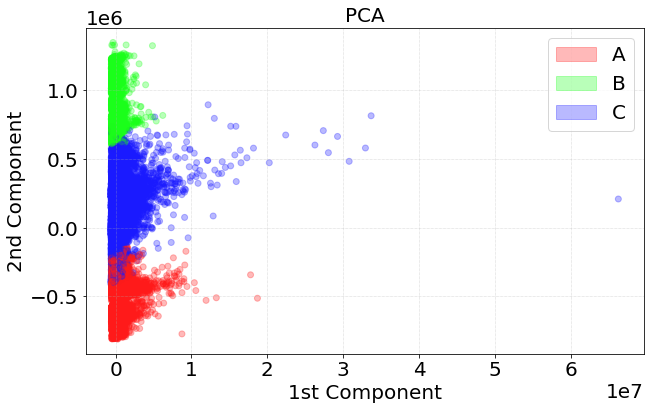

In [26]:
plot_regions(X_pca_2, y_pca, title="PCA", file_name='regioni')

Indago con un dataset bisimensionale il comportamento di k-means sfruttando la rappresentazione grafica

In [27]:
est, y_pred = kmeans_clustering(X_pca_2)

[0 0 0 ... 0 0 0]


In [28]:
print('True     ', y_true[:35],)
print('Predicted', y_pred[:35],)

True      [0 2 2 0 2 0 1 0 0 2 0 0 2 2 2 2 2 1 2 2 2 0 2 2 2 2 1 2 2 0 2 2 0 2 2]
Predicted [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


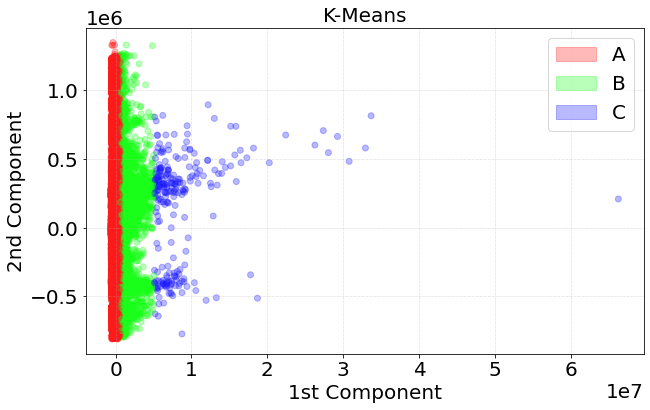

In [29]:
plot_regions(X_pca_2, y_pred, title="K-Means", file_name='k_means')

Il clustering con k_means non individua in maniera precisa i tre cluster, poiché ha il limite di individuare specialmente cluster circolari, differenti da questo particolare caso.

Provo quindi un altro tipo di clustering, DBSCAN

In [30]:
# Validation clustering to tune EPS
def valid_dbscan_clustering(X):
    n_clu      = 1
    CLU_SEARCH = 3
    EPSMIN      = 0.001
    EPSMAX      = 1.
    while(n_clu != CLU_SEARCH and EPSMIN < EPSMAX):
        EPS = (EPSMIN + EPSMAX) / 2
        print(f'EPS: {EPS}, EPSMIN: {EPSMIN}, EPSMAX: {EPSMAX}, NCLU: {n_clu}')
        n_clu = valid_dbscan_clustering_aux(X, EPS)
        if n_clu < CLU_SEARCH:
            EPSMIN = EPS
        else:
            EPSMAX = EPS
    return EPS  

def get_dbscan(X, eps):
    return DBSCAN(eps=eps, min_samples=3, n_jobs=-1).fit(X)

def valid_dbscan_clustering_aux(X, eps):
    X = StandardScaler().fit_transform(X)
    db = get_dbscan(X, eps)
    labels = db.labels_
    n_clu = len(set(labels)) - (1 if -1 in labels else 0)
    print(f'EPS: {eps}, NCLU: {n_clu}')
    return n_clu

In [31]:
X_pca_2.shape

(99709, 2)

In [32]:
# Valido eps su un sottoinsieme dei dati
eps_valid = valid_dbscan_clustering(X_pca_2[:10000])

EPS: 0.5005, EPSMIN: 0.001, EPSMAX: 1.0, NCLU: 1
EPS: 0.5005, NCLU: 5
EPS: 0.25075, EPSMIN: 0.001, EPSMAX: 0.5005, NCLU: 5
EPS: 0.25075, NCLU: 8
EPS: 0.125875, EPSMIN: 0.001, EPSMAX: 0.25075, NCLU: 8
EPS: 0.125875, NCLU: 31
EPS: 0.0634375, EPSMIN: 0.001, EPSMAX: 0.125875, NCLU: 31
EPS: 0.0634375, NCLU: 88
EPS: 0.03221875, EPSMIN: 0.001, EPSMAX: 0.0634375, NCLU: 88
EPS: 0.03221875, NCLU: 216
EPS: 0.016609375, EPSMIN: 0.001, EPSMAX: 0.03221875, NCLU: 216
EPS: 0.016609375, NCLU: 726
EPS: 0.0088046875, EPSMIN: 0.001, EPSMAX: 0.016609375, NCLU: 726
EPS: 0.0088046875, NCLU: 524
EPS: 0.00490234375, EPSMIN: 0.001, EPSMAX: 0.0088046875, NCLU: 524
EPS: 0.00490234375, NCLU: 104
EPS: 0.002951171875, EPSMIN: 0.001, EPSMAX: 0.00490234375, NCLU: 104
EPS: 0.002951171875, NCLU: 18
EPS: 0.0019755859374999997, EPSMIN: 0.001, EPSMAX: 0.002951171875, NCLU: 18
EPS: 0.0019755859374999997, NCLU: 4
EPS: 0.0014877929687499999, EPSMIN: 0.001, EPSMAX: 0.0019755859374999997, NCLU: 4
EPS: 0.0014877929687499999, NCL

Per questo specifico valore epsilon individua tre cluster

In [33]:
dbscan = get_dbscan(X_pca_2, eps_valid)

In [34]:
dbscan

DBSCAN(eps=0.0017316894531249998, min_samples=3, n_jobs=-1)

In [35]:
def occurences(l):
    l = list(l)
    return dict((x, l.count(x)) for x in set(l))

In [36]:
occurences(dbscan.labels_)

{0: 4,
 1: 3,
 2: 6,
 3: 3,
 4: 4,
 5: 3,
 6: 4,
 7: 7,
 8: 3,
 9: 3,
 10: 3,
 11: 4,
 -1: 99662}

L'algoritmo individua principalmente outlier e non è in grado di individuare i cluster, questo perché DBSCAN si basa sulla distanza euclidea. Tuttavia i cluster delle regioni non sono ben distanziati nello spazio e DBSCAN non è in grado di separarli

Provo con un algoritmo di Classificazione  dividendo il dataset a metà tra train e test

In [37]:
half = int(len(X_pca)*2/3)

In [38]:
X_class_train   = X_pca  [:half]
X_class_train_2 = X_pca_2[:half]
y_class_train   = y_pca  [:half]


X_class_test    = X_pca  [half:]
X_class_test_2  = X_pca_2[half:]
y_class_test    = y_pca  [half:]

Classificazione usando tutte le colonne

In [39]:
def classifier(X_train, y_train, X_test, y_test):
    rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1)
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    acc = accuracy_score(y_pred, y_test)
    print(f'Accuracy: {acc}')
    plot_confusion_matrix(rfc, X_test, y_test)

Accuracy: 0.9319734031350603


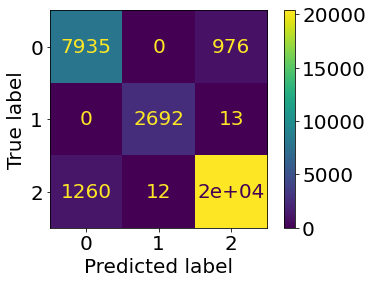

In [40]:
# X con le due feature della PCA
classifier(X_class_train_2, y_class_train, X_class_test_2, y_class_test)

Il classificatore ha un'ottima accuracy

Accuracy: 1.0


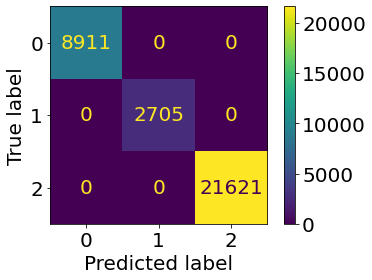

In [41]:
# X con le feature originali
classifier(X_class_train, y_class_train, X_class_test, y_class_test)

La classificazione ha la massima precisione, forse nelle feature ne esiste una con la stessa informazione delle regioni. Provo la classificazione non considerando le colonne legate alla regione.

In [42]:
def classifier_remove_col(X_train, y_train, X_test, y_test, rem_col):
    X_tr = X_train.copy()
    X_te = X_test.copy()
    X_tr = remove_column(X_tr, rem_col)
    X_te = remove_column(X_te, rem_col)
    print(X_tr.shape)
    print(X_te.shape)
    rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1)
    rfc.fit(X_tr, y_train)
    y_pred = rfc.predict(X_te)
    acc = accuracy_score(y_pred, y_test)
    print(f'Accuracy: {acc}')
    plot_confusion_matrix(rfc, X_te, y_test)

In [43]:
prop_lti = list(filter(re.compile("^propertylandusetypeid_.*$").match, list(X_train.columns)))
prop_lti

['propertylandusetypeid_31.0',
 'propertylandusetypeid_246.0',
 'propertylandusetypeid_247.0',
 'propertylandusetypeid_248.0',
 'propertylandusetypeid_260.0',
 'propertylandusetypeid_261.0',
 'propertylandusetypeid_263.0',
 'propertylandusetypeid_264.0',
 'propertylandusetypeid_265.0',
 'propertylandusetypeid_266.0',
 'propertylandusetypeid_267.0',
 'propertylandusetypeid_269.0',
 'propertylandusetypeid_275.0']

In [44]:
regions = ['regionidcity', 'regionidzip', 'rawcensustractandblock']
regions

['regionidcity', 'regionidzip', 'rawcensustractandblock']

In [45]:
fips = list(filter(re.compile("^fips_.*$").match, list(X_train.columns)))
fips

['fips_6037.0', 'fips_6059.0', 'fips_6111.0']

In [46]:
prop_lti + regions + fips

['propertylandusetypeid_31.0',
 'propertylandusetypeid_246.0',
 'propertylandusetypeid_247.0',
 'propertylandusetypeid_248.0',
 'propertylandusetypeid_260.0',
 'propertylandusetypeid_261.0',
 'propertylandusetypeid_263.0',
 'propertylandusetypeid_264.0',
 'propertylandusetypeid_265.0',
 'propertylandusetypeid_266.0',
 'propertylandusetypeid_267.0',
 'propertylandusetypeid_269.0',
 'propertylandusetypeid_275.0',
 'regionidcity',
 'regionidzip',
 'rawcensustractandblock',
 'fips_6037.0',
 'fips_6059.0',
 'fips_6111.0']

(66472, 50)
(33237, 50)
Accuracy: 1.0


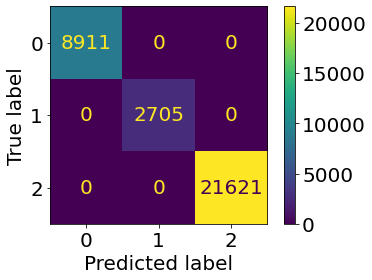

In [47]:
classifier_remove_col(X_class_train, y_class_train, X_class_test, y_class_test, prop_lti + regions + fips)

La classificazione ha comunque il massimo della precisione. Forse in una delle feature condiderate si nasconde comunque un'informazione molto precisa sulla regione

Ad ogni modo questa informazione è semplificata e non più reperibile dopo la PCA, che comunque ha una buona accuray. Deduco che è sensato dividere il dataset in base alla regione di appartenenza

# Split #

Divido il Dataset a seconda del region_id county

In [48]:
# Returns the X, y dataframes splitted throught regions
def split_regionid(X, y):
    A = X.loc[:,regionids[0]] == 1
    B = X.loc[:,regionids[1]] == 1 
    C = X.loc[:,regionids[2]] == 1    
    return X[A], X[B], X[C], y[A], y[B], y[C]

In [49]:
X_trainA, X_trainB, X_trainC, y_trainA, y_trainB, y_trainC = split_regionid(X_train, y_train)
X_valA,   X_valB,   X_valC,   y_valA,   y_valB,   y_valC   = split_regionid(X_val,   y_val  )
X_testA,  X_testB,  X_testC,  y_testA,  y_testB,  y_testC  = split_regionid(X_test,  y_test )

Mantengo i dataframe in un array

In [50]:
X_train = np.array([X_trainA, X_trainB, X_trainC], dtype=object)
X_val   = np.array([X_valA,   X_valB,   X_valC  ], dtype=object)
X_test  = np.array([X_testA,  X_testB,  X_testC ], dtype=object)
y_train = np.array([y_trainA, y_trainB, y_trainC], dtype=object)
y_val   = np.array([y_valA,   y_valB,   y_valC  ], dtype=object)
y_test  = np.array([y_testA,  y_testB,  y_testC ], dtype=object)

In [51]:
for X in [X_train, X_val, X_test]:
    for x in X:
        x = remove_column(x, regionids)

In [52]:
def dimensionality(y=False):
    for i in range(3):
        print(f'X_train{region_names[i]}: {X_train[i].shape}')
        print(f'X_val{region_names[i]}:   {X_val  [i].shape}')
        print(f'X_test{region_names[i]}:  {X_test [i].shape}')
        if y:
            print(f'y_train{region_names[i]}: {y_train[i].shape}')
            print(f'y_val{region_names[i]}:   {y_val  [i].shape}')
            print(f'y_test{region_names[i]}:  {y_test [i].shape}')
            print()

In [53]:
dimensionality(y=True)

X_trainA: (26819, 69)
X_valA:   (9006, 69)
X_testA:  (9085, 69)
y_trainA: (26819, 1)
y_valA:   (9006, 1)
y_testA:  (9085, 1)

X_trainB: (8119, 69)
X_valB:   (2658, 69)
X_testB:  (2606, 69)
y_trainB: (8119, 1)
y_valB:   (2658, 1)
y_testB:  (2606, 1)

X_trainC: (64771, 69)
X_valC:   (21908, 69)
X_testC:  (21876, 69)
y_trainC: (64771, 1)
y_valC:   (21908, 1)
y_testC:  (21876, 1)



In [54]:
dir_name = 'regioni'

for i in range(3):
    X_train[i].to_csv( dir_name + f'/X_train{region_names[i]}.csv',  index=False)
    X_val  [i].to_csv( dir_name + f'/X_val{  region_names[i]}.csv',  index=False)
    X_test [i].to_csv( dir_name + f'/X_test{ region_names[i]}.csv',  index=False)
    y_train[i].to_csv( dir_name + f'/y_train{region_names[i]}.csv',  index=False)
    y_val  [i].to_csv( dir_name + f'/y_val{  region_names[i]}.csv',  index=False)
    y_test [i].to_csv( dir_name + f'/y_test{ region_names[i]}.csv',  index=False)    